# Probability & Statistics 2

## Readings
Read through TS Ch. 3-4 in order to understand the concepts of

* probability mass function (PMF)
* normalization
* "class size paradox"
* cumulative distribution function (CDF)
* percentiles
* median
* interquartile range
* replacement (sampling)

You should ignore the ThinkStats-specific code fragments, but understand how to do the same thing using numpy and scipy stats functions.

## TS Exercise 3.1 (adapted) 

Something like the class size paradox appears if you survey children and ask how many children are in their family. Families with many children are more likely to appear in your sample, and families with no children have no chance to be in the sample. 

* For this exercise, we will need to use the NUMKDHH attribute from the 2013-2015 Respondent data set. To save you some time, the NUMKDHH column has been extracted (using the unix "cut" command) into a file that you can download from the course website. 

* Use the NSFG respondent variable NUMKDHH to construct the actual distribution for the number of children under 18 in the household. It is recommended that you do NOT use the Counter data structure in Python to do this. Since the number of children in a family are integers that range from 0 to 5, you can use an array to store their counts or probabilities (and use the index to implicitly represent the number of children).

* Normalize the distribution into a probabily mass function (that sums to one). Each entry in the dictionary will represent the probability $P(i)$ where $i$ is the number of children in the family.

* Now compute the biased distribution we would see if we surveyed the children and asked them how many children under 18 (including themselves) are in their household. The way to think about this is: 

  1. we randomly pick a child and ask the child how many children are in his/her family (we assume the child will answer truthfully); 
  2. Suppose our sample consists of $n$ children. Now we count/calculate the number of children in our sample that will answer 1, 2, 3, ... etc. 
  3. Since the sample is a (uniform) random sample of the NUMKDHH PMF, the number of children answering $i$ will be $n \cdot P(i)$
  4. Now find the PMF of the sample

* Plot the actual and biased distributions (you might find that seaborn.distplot is not so convenient in this case), and compute their means.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sqlite3
import pprint
from collections import Counter

sns.set(color_codes=True)

# load the data
# each row is the answer to "how many children are in your family"
fname = 'numkdhh.txt'

with open(fname) as file:
    numkdhh = [int(x) for x in file.readlines()]

# If you find the max of the numkdhh array, it is 5
# so an array of size 6 is sufficient to store the frequency counts
dist = np.zeros(6)
for x in numkdhh:
    dist[x]+=1

# normalize the frequency into a PMF and find the mean as well
m1 = 0.0
for i in range(6):
    dist[i] /= len(numkdhh)
    m1 += i*dist[i]

print(dist)

# The following code is a mathematical short cut to finding the 
# bias distribution from the thought experiment 
biasdist = np.zeros(6)
total=0.0
for i in range(6):
    biasdist[i] = dist[i] * i
    total += biasdist[i]

# normalize the frequency into a PMF
m2 = 0.0
for i in range(6):
    biasdist[i] /= total
    m2 += i*biasdist[i]

print(biasdist)

print('m1 = ' + str(m1))
print('m2 = ' + str(m2))

plt.rcParams['figure.figsize'] = [10, 8]


plt.plot(range(6), dist, 'g',label='unbiased')
plt.plot(range(6), biasdist,'r', label='biased')
plt.xlabel("# children in family")
plt.ylabel("Probability")
plt.title("Nnbiased and biased PMF")
plt.legend()
plt.show()


[ 0.49061239  0.20073697  0.17845236  0.09036673  0.02982979  0.01000175]
[ 0.          0.20112518  0.35759494  0.27162447  0.11954993  0.05010549]
m1 = 0.998069836813
m2 = 2.45991561181


Try to make sense of the paradox. What resulted in the difference in the two means?

You can also take a look at this [blog](https://owenbiesel.com/2017/03/01/the-class-size-paradox/)

## Alternate Simulation

There are actually two different effects from two different causes that are clouding the issue, so let's tease them apart.

Let's first address the issue of not sampling the respondents with no children. 

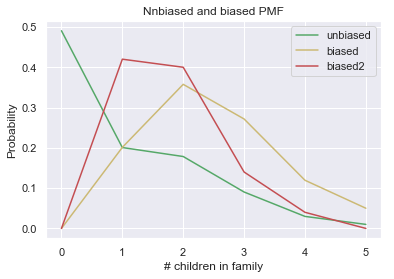

In [2]:
# Alternate way of finding the bias distribution

# Let's get rid of the zeroes, i.e., the respondents who answered zero
# for the question on how many children in the family
data = []
for x in numkdhh:
    if x>0:
        data.append(x)

# convert to numpy array, coz i want to use the fancy sampling functions
biasdata = np.array(data)

# simulate the sampling of children to answer the question 
# "how many siblings do you have?" and add 1 to that number
n = 100
biasdist2=np.zeros(6)
sample = np.random.choice(biasdata,size=n,replace=False)

# count the num children per family reported by the sampled child
for i in range(n):
    biasdist2[sample[i]] += 1
    
# normalize the distribution into a PMF
for i in range(6):
    biasdist2[i] /= n

plt.plot(range(6), dist, 'g',label='unbiased')
plt.plot(range(6), biasdist,'y', label='biased')
plt.plot(range(6), biasdist2,'r', label='biased2')
plt.xlabel("# children in family")
plt.ylabel("Probability")
plt.title("Nnbiased and biased PMF")
plt.legend()
plt.show()


## What's going on?

We see that accounting for the biased sampling did not fully account for the class size paradox, so what is going on?

It turns out that the key to understanding the paradox is to look at the underlying "event space" that define the probabilities. Recall that a random variable is always defined over an "event space". For the initial probabilities derived from numkdhh, let's call the random variable $X$ for the number of children associated with each respondent family. The underlying event space is the set of response/respondents. You can think of the event space as the set associated with the denominator used to normalize the occurrence counts into probabilities.

For the (thought) experiment where we sample from the children in order to ask them about the number of children in their family, let's call the random variable $Y$. The underlying event space for $Y$ is the set of children of the respondents and NOT the respondents. What is the relationship between the cardinality of the set of children versus the set of respondents?

So when we sample a child to be part of the sample, we are choosing from a much bigger set than  the set of respondents with children!

And when we normalize the distribution from the sample, the denominator represents the set of children nor respondents!

Now, how do we simulate this new "population" or "event space" from numkdhh array?

5688


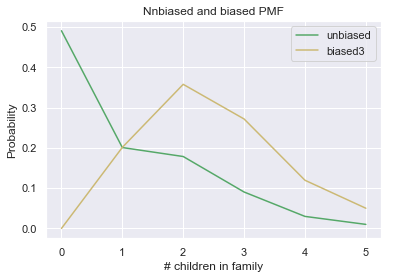

In [6]:
childrendata = []
# all children in the family will answer the same number
family = [[],[1],[2,2],[3,3,3],[4,4,4,4],[5,5,5,5,5]]
for x in numkdhh:
    if x>0 and x < 6:
        childrendata.extend(family[x])
print(len(childrendata))

biasdist3 = {}
biasdist3 = np.zeros(6)

# count the num children per family reported by the sampled child
for x in childrendata:
    biasdist3[x] += 1
    
# normalize the distribution into a PMF
for i in range(6):
    biasdist3[i] /= len(childrendata)

plt.plot(range(6), dist, 'g',label='unbiased')
plt.plot(range(6), biasdist3,'y', label='biased3')
#plt.plot(range(6), biasdist,'r', label='biased')
plt.xlabel("# children in family")
plt.ylabel("Probability")
plt.title("Nnbiased and biased PMF")
plt.legend()
plt.show()

Observe that the way we calculated biasdist in the very first code cell is a mathematical short cut to the simulation code in the above cell!